Valeurs manquantes par colonne :
Series([], dtype: int64)

Statistiques descriptives :
         MSSubClass     MSZoning  LotFrontage       LotArea       Street  \
count  1.460000e+03  1460.000000  1460.000000  1.460000e+03  1460.000000   
mean  -8.881784e-17     3.028767    69.863699 -4.866731e-17     0.995890   
std    1.000343e+00     0.632017    22.027677  1.000343e+00     0.063996   
min   -8.725628e-01     0.000000    21.000000 -9.237292e-01     0.000000   
25%   -8.725628e-01     3.000000    60.000000 -2.969908e-01     1.000000   
50%   -1.631095e-01     3.000000    69.000000 -1.040633e-01     1.000000   
75%    3.098594e-01     3.000000    79.000000  1.087080e-01     1.000000   
max    3.147673e+00     4.000000   313.000000  2.051827e+01     1.000000   

             Alley     LotShape  LandContour    Utilities    LotConfig  ...  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean      0.993836     2.591781     2.777397     2.998630     3.019178

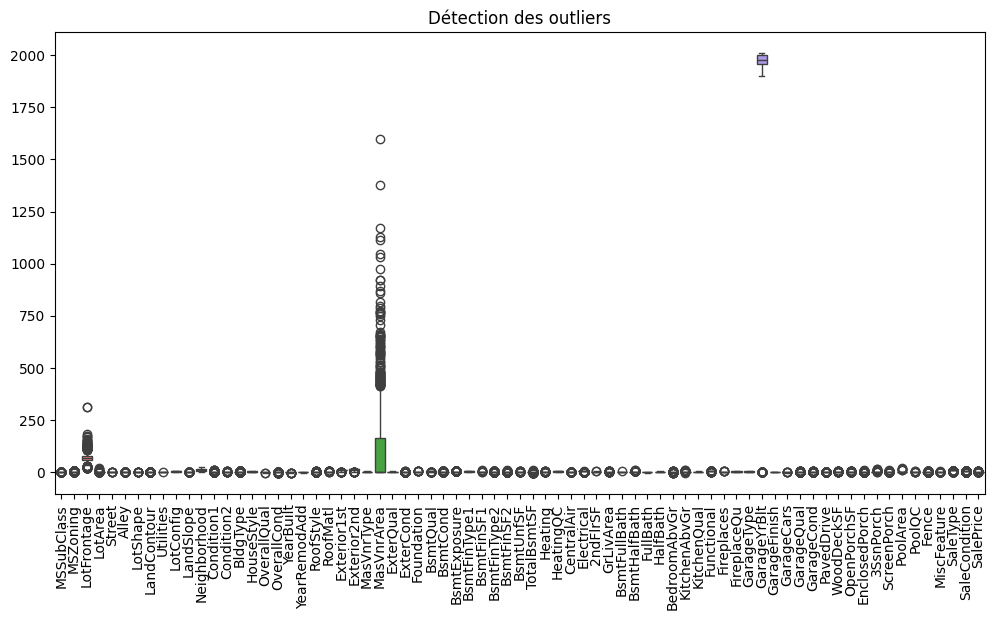

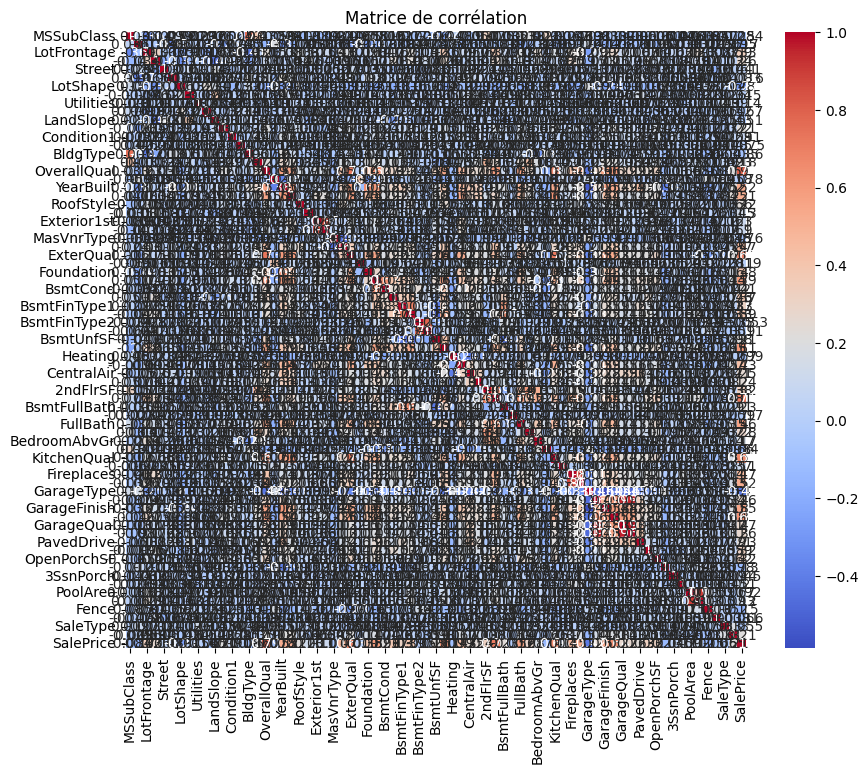


Asymétrie des variables :
MSSubClass        1.406210
MSZoning         -1.733612
LotFrontage       2.406671
LotArea          12.195142
Street          -15.502821
LotShape         -1.308639
LandContour      -3.159249
Utilities       -38.170678
LotConfig        -1.134465
LandSlope        -4.808735
Condition1        3.016093
Condition2       13.158307
BldgType          2.243340
RoofStyle         1.472282
RoofMatl          8.101068
MasVnrArea        2.674865
ExterCond         1.395783
BsmtQual         -1.286247
BsmtCond         -3.697230
BsmtExposure      1.101835
BsmtFinSF1        1.683771
BsmtFinType2      3.293608
BsmtFinSF2        4.250888
TotalBsmtSF       1.522688
Heating           9.844972
CentralAir       -3.526757
Electrical       -3.025325
GrLivArea         1.365156
BsmtHalfBath      4.099186
KitchenAbvGr      4.483784
Functional       -4.907166
GarageYrBlt      -3.865524
GarageQual       -3.225265
GarageCond       -3.328476
PavedDrive       -3.305538
WoodDeckSF        1.539792
O

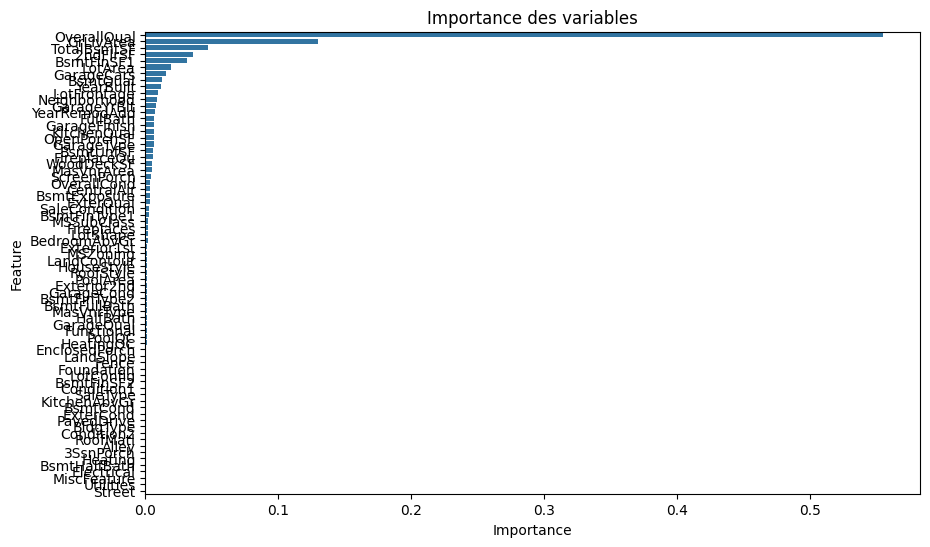

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import skew

# Charger les données
train = pd.read_csv("./final_data.csv")

# Vérifier les valeurs manquantes
missing_values = train.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values[missing_values > 0])

# Remplissage des valeurs manquantes (exemple avec la médiane)
train.fillna(train.median(), inplace=True)

# Vérification des statistiques de base
print("\nStatistiques descriptives :")
print(train.describe())

# Détection des outliers avec IQR
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
outliers = ((train < (Q1 - 1.5 * IQR)) | (train > (Q3 + 1.5 * IQR))).sum()
print("\nNombre d'outliers par colonne :")
print(outliers[outliers > 0])

# Visualisation des outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=train)
plt.xticks(rotation=90)
plt.title("Détection des outliers")
plt.show()

# Analyse de la corrélation
correlation_matrix = train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title("Matrice de corrélation")
plt.show()

# Vérification de la distribution des features
skewness = train.apply(lambda x: skew(x.dropna()))
print("\nAsymétrie des variables :")
print(skewness[abs(skewness) > 1])  # Variables fortement asymétriques

# Prétraitement : Séparation des features et target
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

# Encodage des variables catégorielles si nécessaire
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparer les données en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Tester un modèle robuste (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\nMean Squared Error (MSE) : {mse:.4f}')
print(f'R² Score : {r2:.4f}')

# Importance des variables
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])
plt.title("Importance des variables")
plt.show()
